In [1]:
import warnings

import numpy as np
import timecorr as tc
import seaborn as sns
import os
from matplotlib import pyplot as plt
from matplotlib import gridspec
from scipy.stats import wishart
import hypertools as hyp
from scipy.spatial.distance import cdist

from timecorr.simulate import random_corrmat, ramping_dataset, block_dataset, constant_dataset, random_dataset

%matplotlib inline

LEGEND_SIZE = 12
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [2]:
import sys
sys.executable

'/usr/local/opt/python/bin/python3.6'

In [3]:
figdir = '../figs'
if not os.path.isdir(figdir):
    os.mkdir(figdir)

In [4]:
def identity_compare(obs_corrs=None):
    if obs_corrs is None:
        return 1
    
    return [obs_corrs]

def first_compare(obs_corrs=None):
    if obs_corrs is None:
        return 1
    
    T = obs_corrs.shape[0]
    return [np.tile(obs_corrs[0, :], [T, 1])]

def last_compare(obs_corrs=None):
    if obs_corrs is None:
        return 1
    
    T = obs_corrs.shape[0]
    return [np.tile(obs_corrs[-1, :], [T, 1])]

def ramping_compare(obs_corrs=None):
    if obs_corrs is None:
        return 2
    
    T = obs_corrs.shape[0]
    return [np.tile(obs_corrs[0, :], [T, 1]), np.tile(obs_corrs[-1, :], [T, 1])]

def block_compare(obs_corrs=None):
    if obs_corrs is None:
        return B
    
    T = obs_corrs.shape[0]
    block_len = np.ceil(T / B)
    
    bs = np.repeat(np.atleast_2d(np.arange(B)).T, block_len, axis=0)
    bs = bs[:T, :]
    
    obs_parsed = []
    for b in np.arange(B):
        i = np.where(bs == b)[0][0]
        obs_parsed.append(np.tile(obs_corrs[i, :], [T, 1]))
    return obs_parsed


In [5]:
def plot_ribbon(ts, xs, color='k', ribbon_alpha=0.2, ax=None, xlab=None, ylab=None):
    mean = np.mean(xs, axis=0)
    ci = 1.96 * np.divide(np.std(xs, axis=0), np.sqrt(xs.shape[0]))
    
    if ax == None:
        ax = plt.gca()
    plt.sca(ax)
    
    h1 = ax.fill_between(ts, mean - ci, mean + ci, color=color, alpha=ribbon_alpha)
    h2 = ax.plot(ts, mean, color=color)
    
    if not (xlab == None):
        plt.xlabel(xlab)
    
    if not (ylab == None):
        plt.ylabel(ylab)
    
    return h1, h2

In [6]:
#look into this: https://matplotlib.org/users/gridspec.html
def make_subplots(N, K, legend, corrmap):
    C = 3
    width = C*(N + int(legend)) + int(corrmap)
    height = C
    
    fig = plt.gcf()
    fig.set_size_inches(w=C*(N+int(legend)+int(corrmap)), h=height)
    gs = gridspec.GridSpec(nrows=height, ncols=width, wspace=0.0)
    gs.update(left=0, right=1, wspace=0.1)
    
    #fig.tight_layout(pad=0, h_pad=None, w_pad=None, rect=None)
    
    axes = []
    for n in np.arange(N + int(legend)):
        a = ()
        axes.append(plt.subplot(gs[:, (C * n):((C * (n + 1) -1))]))
    
    if corrmap:
        n = N + int(legend)
        sub_gs = gridspec.GridSpecFromSubplotSpec(K, 1, subplot_spec=gs[:, (C * n):((C * (n + 1) -1))], hspace=0.1)
        for k in np.arange(K):
            axes.append(plt.subplot(sub_gs[k, :]))
    return fig, axes

In [7]:
def format_subplots(ax, N):
    #timeseries plots
    xlim = [np.inf, -np.inf]
    ylim = [np.inf, -np.inf]
    
    for n in np.arange(N):
        next_xlim = ax[n].get_xlim()
        next_ylim = ax[n].get_ylim()
        
        if next_xlim[0] < xlim[0]:
            xlim[0] = next_xlim[0]
        
        if next_ylim[0] < ylim[0]:
            ylim[0] = next_ylim[0]
        
        if next_xlim[1] > xlim[1]:
            xlim[1] = next_xlim[1]
        
        if next_ylim[1] > ylim[1]:
            ylim[1] = next_ylim[1]
    
    for n in np.arange(N):
        ax[n].set_xlim(xlim)
        ax[n].set_ylim(ylim)
        if n > 0:
            ax[n].set_yticklabels([])
    
    return xlim, ylim

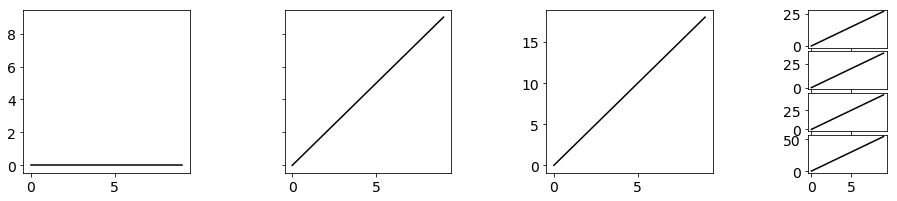

In [8]:
N = 2
K = 4
fig, ax = make_subplots(N, K, True, True);
for i, a in enumerate(ax):
    a.plot(np.arange(10), i*np.arange(10), 'k')
format_subplots(ax, N);

In [9]:
def recovery_test_multi(K, T, N, kernels, ave=False, datagen=ramping_dataset, testfuns=[identity_compare], legend=True, corrmap=False, titles=None, xlab='Time', ylab='Correlation'):
    
    def add_to_axis(ts, corrs, colors, ax):        
        for i in np.arange(len(kernels)):
            plot_ribbon(ts, corrs[i], color=colors[i], ax=ax)
        ax.set(xlim=[0, T-1])
        if not (xlab == None):
            ax.set(xlabel=xlab)
    
    def recovery_corrs(truth, guess):
        if type(truth) is list:
            c_sum = np.zeros()
        return np.diag(1 - cdist(truth[:, K:], guess[:, K:], 'correlation'))

    def mean_retain_dim(arr, ax_val):
        return np.expand_dims(np.mean(arr, axis=ax_val), axis=ax_val)
    
    J = 0
    for t in testfuns:
        J += t()
    
    corr_tests = []
    for i in np.arange(J):
        x = []
        for j in np.arange(len(kernels)):
            x.append(np.zeros([N, T]))
        corr_tests.append(x)
    
    if corrmap:
        recovered_tcorr_mat = []
        for k in kernels:
            recovered_tcorr_mat.append(np.zeros([T, T]))
    
    for n in np.arange(N):
        next_Y, next_corrs = datagen(K, T)
        for i, k in enumerate(kernels):
            recovered_corrs = tc.timecorr(next_Y, weights_function=k['weights'], weights_params=k['params'])
            j = 0
            for t in np.arange(len(testfuns)):
                obs_parsed = testfuns[j](next_corrs)
                for next_obs in obs_parsed:
                    corr_tests[j][i][n, :] = recovery_corrs(next_obs, recovered_corrs)
                    j += 1
            if corrmap:
                recovered_tcorr_mat[i] = recovered_tcorr_mat[i] + tc.helpers.r2z(1 - cdist(next_corrs, recovered_corrs, 'correlation'))
    if corrmap:
        for i in np.arange(len(kernels)):
            recovered_tcorr_mat[i] = tc.helpers.z2r(np.divide(recovered_tcorr_mat[i], N))
    
    corr_test_array = np.array(corr_tests)

    if ave:
        averaged = {'name': 'Average'}
        delta_in = {'name': '$\delta$'}
        delta = {'name': '$\delta$', 'weights': tc.eye_weights, 'params': tc.eye_params}
        gaussian = {'name': 'Gaussian', 'weights': tc.gaussian_weights, 'params': {'var': width}}
        laplace = {'name': 'Laplace', 'weights': tc.laplace_weights, 'params': {'scale': width}}
        mexican_hat = {'name': 'Mexican hat', 'weights': tc.mexican_hat_weights, 'params': {'sigma': width}}
        kernels = [delta, gaussian, laplace, mexican_hat]
#         kernels.append(averaged)
        kernels=[averaged, delta, gaussian, laplace, mexican_hat]

    n = 0
    if legend:
        n += 1
    if corrmap:
        n += len(kernels)
    
    colors = sns.color_palette("husl", n_colors=len(kernels))

        
    fig, ax = make_subplots(J, len(kernels), legend, corrmap)
    
    ts = np.arange(T)
    for i in np.arange(J):
        corr_test_array = np.array(corr_tests[i])
        if ave:
            
            ind_arrays = np.delete(np.arange(corr_test_array.shape[0]), np.arange(0, corr_test_array.shape[0], 4))
            
            new_corr_tests = mean_retain_dim(corr_test_array[ind_arrays, :, :], ax_val=0)
            new_corr_tests = np.concatenate([new_corr_tests, corr_test_array])
            #add_to_axis(ts, np.concatenate([corr_test_array, mean_retain_dim(corr_test_array, ax_val=0)]), colors, ax[i])
            #add_to_axis(ts, mean_retain_dim(corr_test_array, ax_val=0), colors, ax[i])
            add_to_axis(ts, new_corr_tests, colors, ax[i])
            #add_to_axis(ts, np.concatenate([mean_retain_dim(corr_test_array[::4], ax_val=0), mean_retain_dim(corr_test_array[ind_arrays, :, :], ax_val=0)]), colors, ax[i])
        else:
            add_to_axis(ts, corr_tests[i], colors, ax[i])

    if not (ylab == None):
        ax[0].set(ylabel=ylab)    
    
    if legend:
        hs = []
        for i in np.arange(len(kernels)):
            hs.append(ax[-n].plot(ts, np.ones_like(ts), color=colors[i]))
        ax[-n].legend(list(map(lambda x: x['name'], kernels)), loc='center', frameon=False)
        ax[-n].axis('off')
        for h in hs:
            h[0].set_visible(False)
    
    xlim, ylim = format_subplots(ax, J)
    
    if corrmap:                    
        for i in np.arange(len(kernels)):
            sns.heatmap(recovered_tcorr_mat[i], ax=ax[-n+i+1], vmin=ylim[0], vmax=ylim[1], cbar=False)
            ax[-n+i+1].set_xticks([])
            ax[-n+i+1].set_yticks([])
    
    if not (titles == None):
        if not (type(titles) == list):
            titles = [titles]*(len(ax)-n)
        for i, a in enumerate(ax):
            if i > len(ax) - (n + 1):
                break
            a.set_title(titles[i])
    
    

In [10]:
K = 50
T = 300
N = 10

In [11]:
# width = 10
# delta = {'name': '$\delta$', 'weights': tc.eye_weights, 'params': tc.eye_params}
# gaussian = {'name': 'Gaussian', 'weights': tc.gaussian_weights, 'params': {'var': width}}
# laplace = {'name': 'Laplace', 'weights': tc.laplace_weights, 'params': {'scale': width}}
# mexican_hat = {'name': 'Mexican hat', 'weights': tc.mexican_hat_weights, 'params': {'sigma': width}}
# kernels = [delta, gaussian, laplace, mexican_hat]
# #kernels = [delta, gaussian]

# K = 50
# T = 300
# N = 10

In [12]:
# recovery_test_multi(K, T, N, kernels, ave=True, datagen=ramping_dataset, testfuns=[identity_compare, ramping_compare], titles=['Ramping', 'First', 'Last'])
# plt.gcf().savefig(os.path.join(figdir, f'ramping_recovery_{width}.pdf'), bbox_inches='tight')

## For average across all:

In [13]:
widths = [5, 10, 20, 50]
d = {}
for width in widths:
    d['delta{}'.format(width)] = {'name': '$\delta$', 'weights': tc.eye_weights, 'params': tc.eye_params}
    d['gaussian{}'.format(width)] = {'name': 'Gaussian', 'weights': tc.gaussian_weights, 'params': {'var': width}}
    d['laplace{}'.format(width)] = {'name': 'Laplace', 'weights': tc.laplace_weights, 'params': {'scale': width}}
    d['mexican_hat{}'.format(width)] = {'name': 'Mexican hat', 'weights': tc.mexican_hat_weights, 'params': {'sigma': width}}
    
kernels = d.values()
    

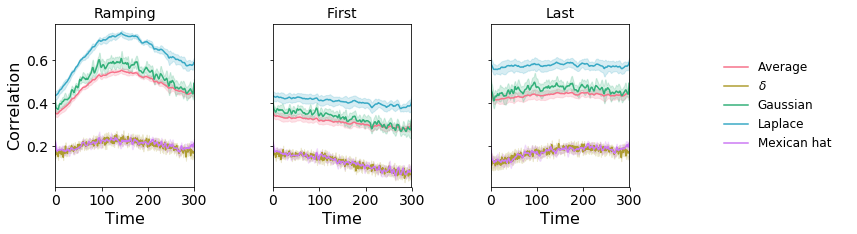

In [14]:
recovery_test_multi(K, T, N, kernels, ave=True, datagen=ramping_dataset, testfuns=[identity_compare, ramping_compare], titles=['Ramping', 'First', 'Last'])
plt.gcf().savefig(os.path.join(figdir, f'ramping_recovery_averaged.pdf'), bbox_inches='tight')

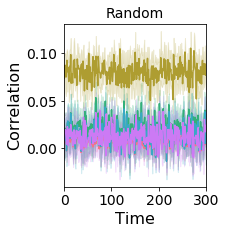

In [15]:
recovery_test_multi(K, T, N, kernels, ave=True, datagen=random_dataset, testfuns=[identity_compare], titles=['Random'], legend=False)
plt.gcf().savefig(os.path.join(figdir, f'random_recovery_averaged.pdf'), bbox_inches='tight')

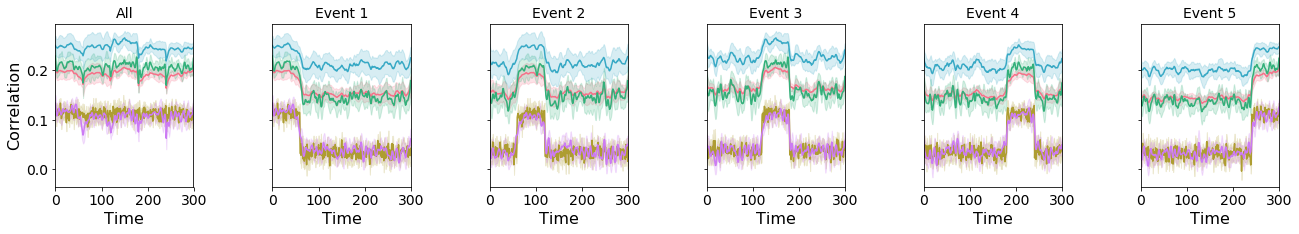

In [16]:
B = 5
titles = ['All']
titles.extend(list(map(lambda b: f'Event {b+1}', np.arange(B))))
recovery_test_multi(K, T, N, kernels, ave=True, datagen=block_dataset, testfuns=[identity_compare, block_compare], titles=titles, legend=False)
plt.gcf().savefig(os.path.join(figdir, f'block_recovery_averaged.pdf'), bbox_inches='tight')

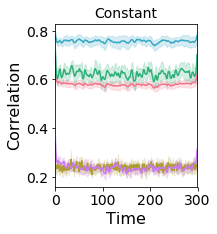

In [17]:
recovery_test_multi(K, T, N, kernels, ave=True, datagen=constant_dataset, testfuns=[identity_compare], titles=['Constant'], legend=False)
plt.gcf().savefig(os.path.join(figdir, f'constant_recovery_averaged.pdf'), bbox_inches='tight')